# X_clustered vs Sampling the Train Cluster by Cluster

In order to improve our lag_regression_ensemble model, we are going to compare its validation loss against different models that are trained on various data sets constructed by sampling from the X clusters.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.preprocessing import StandardScaler
import os
import gc
import warnings
from tqdm.notebook import tqdm
from collections import defaultdict
import time
warnings.filterwarnings('ignore')

In [31]:
train = pd.read_parquet('X_clustered.parquet')

Y = pd.read_parquet('data/train.parquet')['label']

## The Model

Defined in the same way as in the lag_reg_ensemble notebook.

In [7]:
class IncrementalLagEnsemble:
    """Incrementally trains models on different lag configurations using SGD."""
    
    def __init__(self, feature_batch_size=20, lag_batch_size=5, n_epochs=9):
        self.feature_batch_size = feature_batch_size
        self.lag_batch_size = lag_batch_size
        self.n_epochs = n_epochs  
        self.models = {}
        self.scalers = {}
        self.feature_names = None
        self.model_weights = {}
        self.performance_history = defaultdict(list)
        
        # Define lag strategies with odd/even splits for many configurations
        self.lag_strategies = {
            # Original micro lags
            'micro': [1, 2, 3, 4, 5],
            'micro_odd': [1, 3, 5, 7, 9],
            'micro_even': [2, 4, 6, 8, 10],
            
            # Ultra short with odd/even
            'ultra_short': [6, 8, 10, 12, 15],
            'ultra_short_odd': [7, 9, 11, 13, 15, 17],
            'ultra_short_even': [6, 8, 10, 12, 14, 16],
            
            # Short with odd/even
            'short': [20, 25, 30, 40, 50],
            'short_odd': [21, 25, 31, 41, 51],
            'short_even': [20, 24, 30, 40, 50],
            
            # Short medium with odd/even
            'short_medium': [60, 75, 90, 105, 120],
            'short_medium_odd': [61, 75, 91, 105, 121],
            'short_medium_even': [60, 74, 90, 104, 120],
            
            # Medium with odd/even
            'medium': [150, 180, 210, 240, 300],
            'medium_odd': [151, 181, 211, 241, 301],
            
            # Medium long with odd/even
            'medium_long': [360, 420, 480, 540, 600],
            'medium_long_odd': [361, 421, 481, 541, 601],
            
            # Long with odd/even
            'long': [720, 840, 960, 1080, 1200],
            'long_odd': [721, 841, 961, 1081, 1201],
            
            # Very long with odd/even
            'very_long': [1440, 1800, 2160, 2520, 2880],
            'very_long_odd': [1441, 1801, 2161, 2521, 2881],
            
            # Ultra long (keeping original only due to very large values)
            'ultra_long': [3600, 4320, 5040, 5760, 7200]
        }
        
    def create_lag_features_batch(self, df, lag_list):
        """Create lag features for a batch of lags."""
        lag_features = []
        
        for lag in lag_list:
            lagged = df.shift(-lag)
            lagged.columns = [f'{col}_lag_{lag}' for col in df.columns]
            lag_features.append(lagged)
        
        result = pd.concat([df] + lag_features, axis=1)
        result = result.fillna(0)
        
        return result
    
    def train_sgd_model(self, X, y, model_name):
        """Train SGD model incrementally with more epochs."""
        print(f"  Training SGD model: {model_name} ({self.n_epochs} epochs)")
        
        # Initialize model and scaler if not exists
        if model_name not in self.models:
            self.models[model_name] = SGDRegressor(
                loss='huber',
                penalty='elasticnet',
                alpha=0.0001,
                l1_ratio=0.15,
                learning_rate='invscaling',
                eta0=0.01,
                power_t=0.25,
                random_state=42,
                warm_start=True,
                max_iter=1000,
                tol=1e-3
            )
            self.scalers[model_name] = StandardScaler()
            
        model = self.models[model_name]
        scaler = self.scalers[model_name]
        
        # Train in epochs with smaller chunks for better convergence
        chunk_size = 25000  # Slightly smaller chunks for more updates
        for epoch in range(self.n_epochs):
            # Shuffle indices for each epoch
            indices = np.random.permutation(len(X))
            
            for start_idx in range(0, len(X), chunk_size):
                end_idx = min(start_idx + chunk_size, len(X))
                
                # Get shuffled chunk
                chunk_indices = indices[start_idx:end_idx]
                X_chunk = X.iloc[chunk_indices]
                y_chunk = y[chunk_indices]
                
                # Scale
                if start_idx == 0 and epoch == 0:
                    X_scaled = scaler.fit_transform(X_chunk)
                else:
                    X_scaled = scaler.transform(X_chunk)
                
                # Partial fit
                model.partial_fit(X_scaled, y_chunk)
            
            # Print progress
            if epoch % 3 == 0:
                print(f"    Epoch {epoch+1}/{self.n_epochs} completed")
        
        return model
    
    def train_feature_batch(self, feature_batch, X_full, y, strategy_name, lag_list):
        """Train on a batch of features with specific lags."""
        print(f"\n  Processing feature batch ({len(feature_batch)} features) with {strategy_name} lags")
        
        # Select feature batch
        X_batch = X_full[feature_batch].copy()
        
        # Create lag features
        X_with_lags = self.create_lag_features_batch(X_batch, lag_list)
        
        # Train SGD model
        model_name = f"{strategy_name}_{feature_batch[0]}_{feature_batch[-1]}"
        self.train_sgd_model(X_with_lags, y, model_name)
        
        # Clean up
        del X_batch, X_with_lags
        gc.collect()
        
    def fit(self, X, y):
        """Fit ensemble using incremental training."""
        print("Training Incremental Lag Ensemble with Odd/Even Lag Configurations...")
        print(f"Total epochs per model: {self.n_epochs}")
        
        self.feature_names = X.columns.tolist()
        n_features = len(self.feature_names)
        
        # Split features into batches
        feature_batches = []
        for i in range(0, n_features, self.feature_batch_size):
            batch = self.feature_names[i:i+self.feature_batch_size]
            feature_batches.append(batch)
        
        print(f"Split {n_features} features into {len(feature_batches)} batches")
        print(f"Total lag strategies (including odd/even): {len(self.lag_strategies)}")
        
        # Calculate total lag values
        total_lags = sum(len(lags) for lags in self.lag_strategies.values())
        print(f"Total unique lag values: {total_lags}")
        
        # Train models for each combination of feature batch and lag strategy
        total_models = len(feature_batches) * len(self.lag_strategies)
        model_count = 0
        
        for strategy_name, lag_list in self.lag_strategies.items():
            print(f"\nTraining {strategy_name} strategy (lags: {lag_list})")
            
            for batch_idx, feature_batch in enumerate(feature_batches):
                model_count += 1
                print(f"Progress: {model_count}/{total_models} models")
                
                self.train_feature_batch(feature_batch, X, y, strategy_name, lag_list)
                
                # Clean up periodically
                if batch_idx % 2 == 0:
                    gc.collect()
        
        # Initialize equal weights
        for model_name in self.models:
            self.model_weights[model_name] = 1.0 / len(self.models)
        
        print(f"\nTotal models trained: {len(self.models)}")
        
    def predict_batch(self, X, feature_batch, strategy_name, lag_list):
        """Make predictions for a specific feature batch and lag strategy."""
        model_name = f"{strategy_name}_{feature_batch[0]}_{feature_batch[-1]}"
        
        if model_name not in self.models:
            return None
            
        # Select features
        X_batch = X[feature_batch].copy()
        
        # Create lag features
        X_with_lags = self.create_lag_features_batch(X_batch, lag_list)
        
        # Scale and predict
        X_scaled = self.scalers[model_name].transform(X_with_lags)
        predictions = self.models[model_name].predict(X_scaled)
        
        # Clean up
        del X_batch, X_with_lags, X_scaled
        gc.collect()
        
        return predictions
    
    def predict(self, X):
        """Make ensemble predictions."""
        all_predictions = []
        weights = []
        
        # Recreate feature batches
        n_features = len(self.feature_names)
        feature_batches = []
        for i in range(0, n_features, self.feature_batch_size):
            batch = self.feature_names[i:i+self.feature_batch_size]
            if all(col in X.columns for col in batch):
                feature_batches.append(batch)
        
        # Get predictions from each model
        for strategy_name, lag_list in self.lag_strategies.items():
            for feature_batch in feature_batches:
                pred = self.predict_batch(X, feature_batch, strategy_name, lag_list)
                if pred is not None:
                    all_predictions.append(pred)
                    model_name = f"{strategy_name}_{feature_batch[0]}_{feature_batch[-1]}"
                    weights.append(self.model_weights.get(model_name, 1.0))
        
        # Weighted average
        if all_predictions:
            weights = np.array(weights) / np.sum(weights)
            return np.average(all_predictions, axis=0, weights=weights)
        else:
            return np.zeros(len(X))


In [ ]:
y_train = Y[:-100000].to_numpy().astype(np.float32)

X_train = train.copy()[:-100000]

y_val = Y[-100000:].to_numpy().astype(np.float32)

X_val = train.copy()[-100000:]

t = time.time()

ensemble = IncrementalLagEnsemble(
    feature_batch_size=20,  # Slightly smaller batches due to more features
    lag_batch_size=5,
    n_epochs=9  
)
ensemble.fit(X_train, y_train)

print(f"Training Time: {time.time()-t}")

We compute the correaltion between y_pred_val and y_val.

In [17]:
y_pred_val = ensemble.predict(X_val)

np.cov(y_pred_val, y_val)

array([[0.08127172, 0.27048444],
       [0.27048444, 1.08276444]])

In [15]:
0.27048444/(np.sqrt(1.08276444*0.08127172))

0.9118125576143877

## Heteroskedasticity in our Reg Models

The following cell gives us a simple visualization of the heteroskedasticity in our regression models. Removing the heteroskedasticity does not result in a better preformance, and that is why we did not pursue this idea.

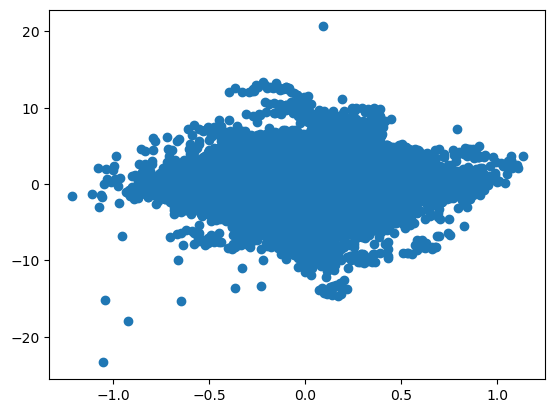

In [70]:
model1 = ensemble.models['long_odd_36_55']

model1_features = [str(i) for i in range(36,56)]

y_model1_pred = ensemble.predict_batch(X_train, model1_features, 'long_odd', [721, 841, 961, 1081, 1201])

model_1_errors = y_train - y_model1_pred

plt.scatter(y_model1_pred, model_1_errors)

plt.show()

## Load the Clusters

In [88]:
clusters = pd.read_csv('clusters.csv', index_col=0)

In [134]:
clusters_dict = defaultdict(list)

for c in np.unique(clusters):
    X = clusters[clusters['0'] == c]
    clusters_dict[c] = X.index.tolist()

## Sampling the Clusters

We sample one by one from each clusters untill all the X features are sampled. Each sampling round is stored in features, and we add it to the features_list at the end of each sampling round.

In [138]:
total = 0

features_list = []

while total<780:
    features = []
    for k in clusters_dict.keys():
        if len(clusters_dict[k])>0:
            features.append(clusters_dict[k][-1])
            clusters_dict[k].pop()
            total += 1
    features_list.append(features)
    features = list([])
    

### The Features_list

There are 24 lists of features in the feature list. We are going to discard the ones that have less than 10 features.

In [142]:
len(features_list)

24

In [162]:
while len(features_list[-1])<10:
    features_list.pop()

In [164]:
features_list[-1]

['X559',
 'X238',
 'X152',
 'X457',
 'X447',
 'X34',
 'X45',
 'X170',
 'X372',
 'X293',
 'X280']

## Train a Model for each List of Features in Features_list

We add the order book data to each element of the features_list, and train a reg_ensemble model on the resulting data set. For each model, we use the last 100000 data points as the validation set.

In [174]:
train_original = pd.read_parquet('data/train.parquet')

order_features = train_original.columns.tolist()[:5]

new_features = order_features+features_list[0]

X_train_new = train_original[new_features][:-100000]

In [ ]:
ensemble_new = IncrementalLagEnsemble(
    feature_batch_size=20,  # Slightly smaller batches due to more features
    lag_batch_size=5,
    n_epochs=9  # Increased to 9 as requested
)

ensemble_new.fit(X_train_new, y_train)

In [178]:
X_val_new = train_original[new_features][-100000:]

y_new_pred = ensemble_new.predict(X_val_new)

np.cov(y_val, y_new_pred)

array([[1.08276444, 0.27547381],
       [0.27547381, 0.08170137]])

## Compute the Score

For each trained model, we compute the correlation between y_val and y_pred. The first model has a better score than the model where we averaged the features over each cluster.

In [27]:
0.27547381/(np.sqrt(1.08276*0.08170137))

0.9261888415763434

## Heteroskedasticity in the New Model

The following is another visualization of heteroskedasticity in our regressions.

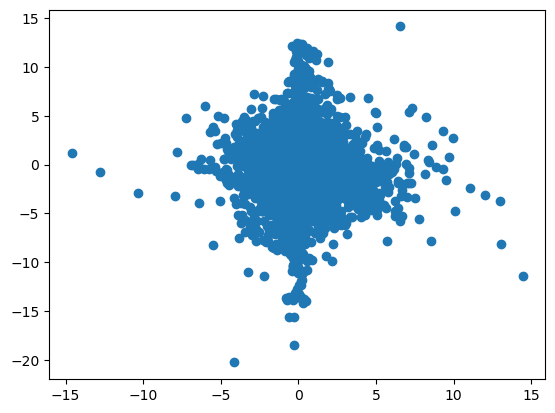

In [206]:
model1 = ensemble_new.models['micro_bid_qty_X501']

model1_features = [X_train_new.columns.tolist()[i] for i in range(20)]

y_model1_pred = ensemble_new.predict_batch(X_train_new, model1_features, 'micro', [1, 2, 3, 4, 5])

model_1_errors = y_train - y_model1_pred

plt.scatter(y_model1_pred, model_1_errors)

plt.show()

Repeat the same procedure for all the models.

In [ ]:
features2 = features_list[1]

X_train_features2 = train_original[order_features+features2][:-100000]

X_val_features2 = train_original[order_features+features2][-100000:]

t = time.time()

ensemble_features2 = IncrementalLagEnsemble(
    feature_batch_size=20,  # Slightly smaller batches due to more features
    lag_batch_size=5,
    n_epochs=9  # Increased to 9 as requested
)

ensemble_features2.fit(X_train_features2, y_train)

print(f"Training Time: {time.time()-t}")

In [212]:
y_pred_features2 = ensemble_features2.predict(X_val_features2)

np.cov(y_val, y_pred_features2)

array([[1.08276444, 0.2761608 ],
       [0.2761608 , 0.08470559]])

In [22]:
0.2761608/(np.sqrt(1.08276*0.08470559))

0.9118846276367727

In [ ]:
features3 = features_list[2]

X_train_features3 = train_original[order_features+features3][:-100000]

X_val_features3 = train_original[order_features+features3][-100000:]

t = time.time()

ensemble_features3 = IncrementalLagEnsemble(
    feature_batch_size=18,  # Slightly smaller batches due to more features
    lag_batch_size=5,
    n_epochs=9  # Increased to 9 as requested
)

ensemble_features3.fit(X_train_features3, y_train)

print(f"Training Time: {time.time()-t}")

In [232]:
y_pred_features3 = ensemble_features3.predict(X_val_features3)

np.cov(y_val, y_pred_features3)

array([[1.08276444, 0.26886823],
       [0.26886823, 0.07903744]])

In [24]:
0.26886823/(np.sqrt(1.08276*0.07903744))

0.9190876996564301

In [ ]:
features4 = features_list[3]

X_train_features4 = train_original[order_features+features4][:-100000]

X_val_features4 = train_original[order_features+features4][-100000:]

t = time.time()

ensemble_features4 = IncrementalLagEnsemble(
    feature_batch_size=18,  # Slightly smaller batches due to more features
    lag_batch_size=5,
    n_epochs=9  # Increased to 9 as requested
)

ensemble_features4.fit(X_train_features4, y_train)

print(f"Training Time: {time.time()-t}")

In [240]:
y_pred_features4 = ensemble_features4.predict(X_val_features4)

np.cov(y_val, y_pred_features4)

array([[1.08276444, 0.31785443],
       [0.31785443, 0.11629511]])

In [26]:
0.31785443/(np.sqrt(1.08276*0.11629511))

0.8957389102111529

In [ ]:
features5 = features_list[4]

X_train_features5 = train_original[order_features+features5][:-100000]

X_val_features5 = train_original[order_features+features5][-100000:]

t = time.time()

ensemble_features5 = IncrementalLagEnsemble(
    feature_batch_size=15,  # Slightly smaller batches due to more features
    lag_batch_size=5,
    n_epochs=9  # Increased to 9 as requested
)

ensemble_features5.fit(X_train_features5, y_train)

print(f"Training Time: {time.time()-t}")

In [248]:
y_pred_features5 = ensemble_features5.predict(X_val_features5)

np.cov(y_val, y_pred_features5)

array([[1.08276444, 0.30137438],
       [0.30137438, 0.098665  ]])

In [28]:
0.30137438/(np.sqrt(1.08276*0.098665))

0.9220589084426338

In [ ]:
features6 = features_list[5]

X_train_features6 = train_original[order_features+features6][:-100000]

X_val_features6 = train_original[order_features+features6][-100000:]

t = time.time()

ensemble_features6 = IncrementalLagEnsemble(
    feature_batch_size=15,  # Slightly smaller batches due to more features
    lag_batch_size=5,
    n_epochs=9  # Increased to 9 as requested
)

ensemble_features6.fit(X_train_features6, y_train)

print(f"Training Time: {time.time()-t}")

In [258]:
y_pred_features6 = ensemble_features6.predict(X_val_features6)

np.cov(y_val, y_pred_features6)

array([[1.08276444, 0.30952941],
       [0.30952941, 0.105549  ]])

In [30]:
0.30952941/(np.sqrt(1.08276*0.105549))

0.9156062671349687

In [ ]:
features7 = features_list[6]

X_train_features7 = train_original[order_features+features7][:-100000]

X_val_features7 = train_original[order_features+features7][-100000:]

t = time.time()

ensemble_features7 = IncrementalLagEnsemble(
    feature_batch_size=12,  # Slightly smaller batches due to more features
    lag_batch_size=5,
    n_epochs=9  # Increased to 9 as requested
)

ensemble_features7.fit(X_train_features7, y_train)

print(f"Training Time: {time.time()-t}")

In [264]:
y_pred_features7 = ensemble_features7.predict(X_val_features7)

np.cov(y_val, y_pred_features7)

array([[1.08276444, 0.30261294],
       [0.30261294, 0.10436949]])

In [32]:
0.30261294/(np.sqrt(1.08276*0.10436949))

0.9001908879605925

In [ ]:
features8 = features_list[7]

X_train_features8 = train_original[order_features+features8][:-100000]

X_val_features8 = train_original[order_features+features8][-100000:]

t = time.time()

ensemble_features8 = IncrementalLagEnsemble(
    feature_batch_size=10,  # Slightly smaller batches due to more features
    lag_batch_size=5,
    n_epochs=9  # Increased to 9 as requested
)

ensemble_features8.fit(X_train_features8, y_train)

print(f"Training Time: {time.time()-t}")

In [270]:
y_pred_features8 = ensemble_features8.predict(X_val_features8)

np.cov(y_val, y_pred_features8)

array([[1.08276444, 0.28999669],
       [0.28999669, 0.09543791]])

In [34]:
0.28999669/(np.sqrt(1.08276*0.09543791))

0.9021245032245654

In [ ]:
features9 = features_list[8]

X_train_features9 = train_original[order_features+features9][:-100000]

X_val_features9 = train_original[order_features+features9][-100000:]

t = time.time()

ensemble_features9 = IncrementalLagEnsemble(
    feature_batch_size=12,  # Slightly smaller batches due to more features
    lag_batch_size=5,
    n_epochs=9  # Increased to 9 as requested
)

ensemble_features9.fit(X_train_features9, y_train)

print(f"Training Time: {time.time()-t}")

In [276]:
y_pred_features9 = ensemble_features9.predict(X_val_features9)

np.cov(y_val, y_pred_features9)

array([[1.08276444, 0.30027902],
       [0.30027902, 0.11268181]])

In [ ]:
features10 = features_list[9]

X_train_features10 = train_original[order_features+features10][:-100000]

X_val_features10 = train_original[order_features+features10][-100000:]

t = time.time()

ensemble_features10 = IncrementalLagEnsemble(
    feature_batch_size=9,  # Slightly smaller batches due to more features
    lag_batch_size=5,
    n_epochs=9  # Increased to 9 as requested
)

ensemble_features10.fit(X_train_features10, y_train)

print(f"Training Time: {time.time()-t}")

In [284]:
y_pred_features10 = ensemble_features10.predict(X_val_features10)

np.cov(y_val, y_pred_features10)

array([[1.08276444, 0.33769377],
       [0.33769377, 0.13105059]])

In [36]:
0.33769377/(np.sqrt(1.08276*0.13105059))

0.8964735007529155

In [ ]:
features11 = features_list[10]

X_train_features11 = train_original[order_features+features11][:-100000]

X_val_features11 = train_original[order_features+features11][-100000:]

t = time.time()

ensemble_features11 = IncrementalLagEnsemble(
    feature_batch_size=9,  # Slightly smaller batches due to more features
    lag_batch_size=5,
    n_epochs=9  # Increased to 9 as requested
)

ensemble_features11.fit(X_train_features11, y_train)

print(f"Training Time: {time.time()-t}")

In [294]:
y_pred_features11 = ensemble_features11.predict(X_val_features11)

np.cov(y_val, y_pred_features11)

array([[1.08276444, 0.32141151],
       [0.32141151, 0.12609677]])

In [38]:
0.32141151/(np.sqrt(1.08276*0.12609677))

0.8698479461153206

In [ ]:
features12 = features_list[11]

X_train_features12 = train_original[order_features+features12][:-100000]

X_val_features12 = train_original[order_features+features12][-100000:]

t = time.time()

ensemble_features12 = IncrementalLagEnsemble(
    feature_batch_size=8,  # Slightly smaller batches due to more features
    lag_batch_size=5,
    n_epochs=9  # Increased to 9 as requested
)

ensemble_features12.fit(X_train_features12, y_train)

print(f"Training Time: {time.time()-t}")

In [300]:
y_pred_features12 = ensemble_features12.predict(X_val_features12)

np.cov(y_val, y_pred_features12)

array([[1.08276444, 0.28864215],
       [0.28864215, 0.10244512]])

In [40]:
0.28864215/(np.sqrt(1.08276*0.10244512))

0.8666585209358717